# Waymo Open Dataset Tutorial (using local Jupyter kernel)

- Website: https://waymo.com/open
- GitHub: https://github.com/waymo-research/waymo-open-dataset

This tutorial demonstrates how to use the Waymo Open Dataset with two frames of data. Visit the [Waymo Open Dataset Website](https://waymo.com/open) to download the full dataset.

To use:
1. checkout `waymo_open_dataset` (need to run once):
   ```
   git clone https://github.com/waymo-research/waymo-open-dataset.git waymo-open-dataset-repo
   cd waymo-open-dataset-repo
   ```
2. build docker container (need to run once):
   ```
   docker build --tag=open_dataset -f tutorial/cpu-jupyter.Dockerfile .
   ```
3. start Jupyter kernel inside the docker container:
   ```
   docker run -p 8888:8888 open_dataset
   ```
4. connect the notebook to the local port `8888`.

Uncheck the box "Reset all runtimes before running" if you run this colab directly from the remote kernel. Alternatively, you can make a copy before trying to run it by following "File > Save copy in Drive ...".



### Metrics computation
The core metrics computation library is written in C++, so it can be extended to other programming languages. It can compute detection metrics (mAP) and tracking metrics (MOTA). See more information about the metrics on the [website](https://waymo.com/open/next/).

We provide command line tools and TensorFlow ops to call the detection metrics library to compute detection metrics. We will provide a similar wrapper for tracking metrics library in the future. You are welcome to contribute your wrappers.

#### Command line detection metrics computation

The command takes a pair of files for prediction and ground truth. Read the comment in waymo_open_dataset/metrics/tools/compute_detection_metrics_main.cc for details of the data format.

In [1]:
import os

if os.path.exists('tutorial_local.ipynb'):
    os.chdir('../')

frames_path = '{pyglib_resource}tutorial/frames'.format(pyglib_resource='')

### Load waymo_open_dataset package

In [2]:
import tensorflow as tf
import math
import numpy as np
import itertools

from waymo_open_dataset.utils import frame_utils
from waymo_open_dataset import dataset_pb2 as open_dataset

tf.executing_eagerly()

True

## Read one frame

Each file in the dataset is a sequence of frames ordered by frame start timestamps. We have extracted two frames from the dataset to demonstrate the dataset format.

In [3]:
dataset = tf.data.TFRecordDataset(frames_path, compression_type='')
for data in dataset:
    frame = open_dataset.Frame()
    frame.ParseFromString(bytearray(data.numpy()))
    break

(range_images, camera_projections, range_image_top_pose) = (
    frame_utils.parse_range_image_and_camera_projection(frame))

## Visualize Camera Images

In [4]:
from matplotlib.patches import Rectangle

In [5]:
!pip install Pillow

     |████████████████████████████████| 2.1MB 5.4MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [6]:
from PIL import Image
from io import BytesIO

In [7]:
def save_image(data, save_path):
    image = Image.open(BytesIO(data))
    image.save(save_path)

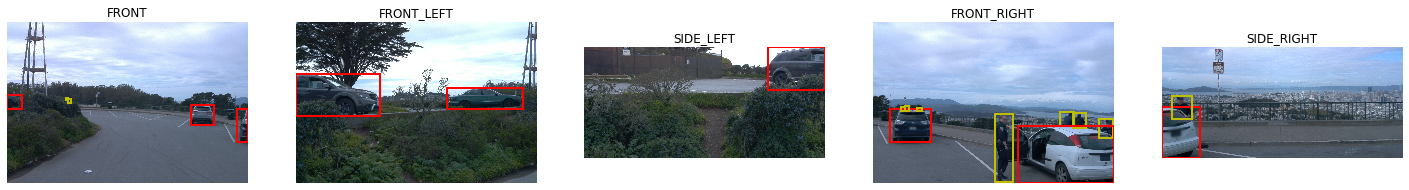

In [8]:
import matplotlib.pyplot as plt

def image_show(fig, data, name, labels, layout, cmap=None):
    ax = fig.add_subplot(*layout)
    ax.imshow(tf.image.decode_jpeg(data), cmap=cmap)
    ax.set_title(name)
    ax.grid(False)
    ax.axis('off')
    for label in labels:
        ax.add_patch(
            Rectangle(
                (label.box.center_x-label.box.length/2, label.box.center_y-label.box.width/2), 
                label.box.length, 
                label.box.width,
                linewidth=2,edgecolor='r' if label.type==1 else 'y',facecolor='none'
            )
        )

def frame_show(frame):
    fig = plt.figure(figsize=(25, 10))
    for index, (image, labels) in enumerate(zip(frame.images, frame.camera_labels)):
        image_show(fig, image.image, open_dataset.CameraName.Name.Name(image.name), labels.labels,
                 [1, 5, index+1])
    plt.show()
    
frame_show(frame)

In [9]:
def count_classes(data, labels):
    num_v = 0
    num_p = 0
    for label in labels:
        if label.type == 1:
            num_v += 1 
        else:
            num_p += 1
        
    lines = []
    for label in labels:
        lines.append(
            '{},{},{},{},{}'.format(
                label.box.center_x, 
                label.box.center_y, 
                label.box.length, 
                label.box.width, 
                label.type
            )
        )
            
    return num_v, num_p, " ".join(lines)

def valid_frame(frame, filename=0, frame_number=0, outfile=0, debug=1):
    fig = plt.figure(figsize=(25, 10))
    for index, (image, labels) in enumerate(zip(frame.images, frame.camera_labels)):
        num_v, num_p, classes = count_classes(
            image.image, labels.labels)
        if debug:
            image_show(
                fig, 
                image.image, 
                "{}-v:{},p:{}".format(
                    open_dataset.CameraName.Name.Name(image.name),
                    str(num_v),
                    str(num_p),
                ), 
                labels.labels,
                [1, 5, index+1]
            )
        elif num_p > 1 and num_v > 1:
            image_name = '{}_{}_{}.jpg'.format(filename, frame_number, open_dataset.CameraName.Name.Name(image.name))
            save_image(image.image, '/data/data/{}'.format(image_name))
            outfile.write('{} {}\n'.format(image_name, classes))
    if debug: 
        plt.show()

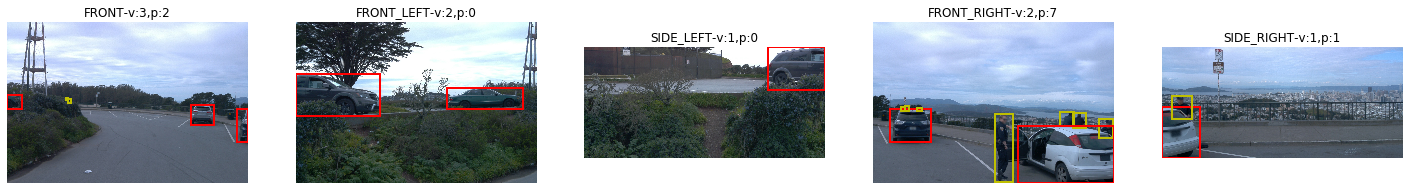

In [10]:
valid_frame(frame)

In [ ]:
debug = 0
INPUT_PATH = '/data/training_0031/'
OUTPUT_PATH = '/data/data/'
outfile = open('/data/dataset.txt', 'a')
for tfrecord in os.listdir(INPUT_PATH):
    if tfrecord == 'LICENSE':
        continue
    dataset = tf.data.TFRecordDataset(
        '{}/{}'.format(INPUT_PATH, tfrecord), 
        compression_type=''
    )
    itercount = 0
    for data in dataset:
        if itercount % 20 == 0:
            print('{}'.format(itercount))
            frame = open_dataset.Frame()
            frame.ParseFromString(bytearray(data.numpy()))
            valid_frame(frame, filename=tfrecord.split('.')[0], frame_number=itercount, outfile=outfile, debug=debug)
        itercount += 1
    if debug:
        break
outfile.close()

In [47]:
infile = open('/data/dataset.txt', 'r')
outfile = open('/data/dataset_corner.txt', 'w')
print(infile.readline())
infile.close()
outfile.close()

segment-10206293520369375008_2796_800_2816_800_with_camera_labels_60_FRONT.jpg 1481.0785499999997,745.90779,18.31610999999998,46.106070000000045,2 795.8034,686.53833,54.31673999999998,51.158789999999954,1 1461.49926,723.17055,32.84267999999997,84.63306,2 1047.80781,666.95904,27.789960000000065,24.000419999999963,1

